In [1886]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import cross_val_score, GridSearchCV
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

In [1887]:
#Read data and make copy
laptop= pd.read_csv('laptop_data.csv')
df= laptop.copy()

Explore DATA

Unknow foreign valuta

In [1888]:
df.head()

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [1889]:
df.shape

(1303, 12)

In [1890]:
print(df.info())
from summarytools import dfSummary
dfSummary(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   TypeName          1303 non-null   object 
 3   Inches            1303 non-null   float64
 4   ScreenResolution  1303 non-null   object 
 5   Cpu               1303 non-null   object 
 6   Ram               1303 non-null   object 
 7   Memory            1303 non-null   object 
 8   Gpu               1303 non-null   object 
 9   OpSys             1303 non-null   object 
 10  Weight            1303 non-null   object 
 11  Price             1303 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 122.3+ KB
None


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Unnamed: 0[int64],Mean (sd) : 651.0 (376.3)min < med < max:0.0 < 651.0 < 1302.0IQR (CV) : 651.0 (1.7),"1,303 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAhpJREFUeJzt1z1PKkEYhuEZQDMCsuHjQEdzSrtNaGjsLP2xtvaQWFOc5lQ0hIQsS1g1bnANRksDu+PXk72vel9mZ7gzAZtlmQF+u8pPvwBwjNqhB6y1Z8aYU1PMU5ZlD6Zkynpm9gv3XTu0cLfbvW61Wu0iK6/X66219tYY8+hx4z//wKzPvOt0OldBEDRKdmbOZ9+bzSay1t58FOuhG/V0H+l4PH4IgiDXwS0Wi/PpdHo5HA571Wo196HvdruTJEn+NpvN/5VKJf2uWd/5NE2dMeZiNBrd9Xq9TVnOLPXYdxzHbjKZtFer1f42LhTqq32k/X7/Ps/iURSdOefqYRg+DgaDyOQ0n8/bs9nsTxiG//LO+8x+0tp151xawjOrF9n3m/3Phg8dFaqPRqORO/L3L63ovM/sZ61d1jP7KvzrhwRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChQRChYTaMQ/FcezyfvB2u32dSZLELZfL+nfOq66t+t7Gc/6Yvl4AZg014jRLyZ0AAAAASUVORK5CYII="">",0(0.0%)
2,Company[object],1. Dell2. Lenovo3. HP4. Asus5. Acer6. MSI7. Toshiba8. Apple9. Samsung10. Mediacom11. other,297 (22.8%)297 (22.8%)274 (21.0%)158 (12.1%)103 (7.9%)54 (4.1%)48 (3.7%)21 (1.6%)9 (0.7%)7 (0.5%)35 (2.7%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAABB1JREFUeJzt3UFq22oARlE5mL5mEhMCXkYW4EV0sV2EF5B9mOIM6r5OXFRc6OQ9SLGu1PicQRoKJR5c5Ej8X706n88DFO6SnwJioyQ2MmIjIzYyYiMjNjJiIyM2MqthGO6HYfgwLMP38/l8mvtFMI3109PTp4eHh8dhAV5fX7+sVqvPgnuf1mNou93utNlsvs35Qo7H48f9fv94OBzGq6zY3qH1+GUMbbvdfp37xVze0nmn3CCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERvtEaPxLNkwsyW8Bqa1Hk/HjocWl3CWbHwt49HwuV8H07BBILPyX2ZRcWUjY11FxrqKjHUVGQ91yYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeNYOBmDF27uyuaKdgMWMXgxdLkNsw9eDF1ux1IGL7PfCTM9D3XJiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNi4ncGLocvtWMTgxdDlNjgWTsbghYwbBP7at1FvhzTrKispknWVlRT1uspKiv/kBoGM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2/b11lJUW6rrKS4v84Fk7GuopFX9lcvWgGL0YtJIMXoxbqwYtRC3/EQ10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzaWOXgxaiEdvBi18KccCydj8MIirmyuYDSDF8MWksGLYQv14MWwhavyUJeM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2Jh3XWVFRbqusqLi2mwQyFhXkXFlI2NdRca6iox1FRkPdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjWDgZgxdmubK5ktEMXgxcmNrdGNrz8/NwWVi95aMg4e3P2e7v7/992z+Dt/NQl4zYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjTa20+n0T/cjuVV346HJl5cXAxcm51g4GYMXMm4QyN9GB2+hJOuq8RvLKpJ1lWUVBb+zkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbHRfpzQ5XvLKiblWDgZ6yoyrmxkDF7IGLyQ8eiDjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MwQsZx8LJGLwwywel/eID05hu8HLZIPw0/g5n/MIU1mNou93utNlsvh2Px4/7/f7xcDiMVzqxcVXr8csY2na7/Xr5u583DHBtnrORERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbHRnvoYjxb9/idMNngZz7D9Olp0GcAYv3B1joWTMXgh4waBjNjIiI2M2MiIjYzYyIiNjNjIiI2h8gNRUAALo6InswAAAABJRU5ErkJggg=="">",0(0.0%)
3,TypeName[object],1. Notebook2. Gaming3. Ultrabook4. 2 in 1 Convertible5. Workstation6. Netbook,727 (55.8%)205 (15.7%)196 (15.0%)121 (9.3%)29 (2.2%)25 (1.9%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAACKCAYAAAC96ziyAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAAmxJREFUeJzt3V1qGmEAhtGZIKW9UYLgYlxEF9tFZDdS9KIpvbFM0VRKKYTGx5+cAwkkN0p4Mmbke8m43+8HKDwkjwJioyQ2MmIjMw7D8GkYhg/dQ74bP/b7/fOln8Q1mS2Xy8/z+fzx0k/k3ux2u6/jOH4R3G+zKbT1ev28WCy+n3yf/7Ddbj8+PT09bjab6RVDbAez6dMU2mq1+nb8Jm9i+vOEE24QyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYaE99TEdiuoe8f36efzebDvlNZ68ciXlb0891Oq176edxTRwLPx/Hwv8wGilzT1c2v+E0gxfDD5LBi+EH9eDFXS6/eFOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNi4j3WVlRHpusrKiCMbBDLWVdzNlc1VjWZdZVlFsq6yrKJeV1lW8cKbumTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTExu2vqyyrSNdVllWcskEgY13FTVzZXLVo1lWWUyTrKssp6nWV5RSv4k1dMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2rnvwYsxCOngxZuG1HA

First column is ID column

Some columns will need extraction of usefull information, dtypes changes needed

No missing values for now



In [1891]:
# check duplicates
df.duplicated().sum()

np.int64(0)

Delete unneeded info

Control incorrect dtypes

In [1892]:
# Dropping Unamed column -> id
df= df.drop('Unnamed: 0', axis=1)

In [1893]:
# Data types
df.dtypes

Company              object
TypeName             object
Inches              float64
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price               float64
dtype: object

In [1894]:
# Convert column names and string values to lowercase for readability
df.columns = df.columns.str.lower()  # Convert column names to lowercase
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)  # Convert string values to lowercase

# Check the result
print(df)

     company            typename  inches  \
0      apple           ultrabook    13.3   
1      apple           ultrabook    13.3   
2         hp            notebook    15.6   
3      apple           ultrabook    15.4   
4      apple           ultrabook    13.3   
...      ...                 ...     ...   
1298  lenovo  2 in 1 convertible    14.0   
1299  lenovo  2 in 1 convertible    13.3   
1300  lenovo            notebook    14.0   
1301      hp            notebook    15.6   
1302    asus            notebook    15.6   

                                screenresolution  \
0             ips panel retina display 2560x1600   
1                                       1440x900   
2                              full hd 1920x1080   
3             ips panel retina display 2880x1800   
4             ips panel retina display 2560x1600   
...                                          ...   
1298   ips panel full hd / touchscreen 1920x1080   
1299  ips panel quad hd+ / touchscreen 3200x1800   
130

C:\Users\Windows 11\AppData\Local\Temp\ipykernel_22764\96063963.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)  # Convert string values to lowercase


In [1895]:
# show amount of unique values in each column
df.nunique()

company              19
typename              6
inches               18
screenresolution     40
cpu                 116
ram                   9
memory               39
gpu                 110
opsys                 9
weight              179
price               791
dtype: int64

In [1896]:
for col in df.select_dtypes(include=["object", "category"]).columns:
    print(f"Unique values in '{col}':")
    print(df[col].unique())
    print("-" * 50)  # Separator for readability

Unique values in 'company':
['apple' 'hp' 'acer' 'asus' 'dell' 'lenovo' 'chuwi' 'msi' 'microsoft'
 'toshiba' 'huawei' 'xiaomi' 'vero' 'razer' 'mediacom' 'samsung' 'google'
 'fujitsu' 'lg']
--------------------------------------------------
Unique values in 'typename':
['ultrabook' 'notebook' 'netbook' 'gaming' '2 in 1 convertible'
 'workstation']
--------------------------------------------------
Unique values in 'screenresolution':
['ips panel retina display 2560x1600' '1440x900' 'full hd 1920x1080'
 'ips panel retina display 2880x1800' '1366x768'
 'ips panel full hd 1920x1080' 'ips panel retina display 2304x1440'
 'ips panel full hd / touchscreen 1920x1080'
 'full hd / touchscreen 1920x1080' 'touchscreen / quad hd+ 3200x1800'
 'ips panel touchscreen 1920x1200' 'touchscreen 2256x1504'
 'quad hd+ / touchscreen 3200x1800' 'ips panel 1366x768'
 'ips panel 4k ultra hd / touchscreen 3840x2160'
 'ips panel full hd 2160x1440' '4k ultra hd / touchscreen 3840x2160'
 'touchscreen 2560x1440' '16

Visualizing Data

checking for association of features with outcome variable price

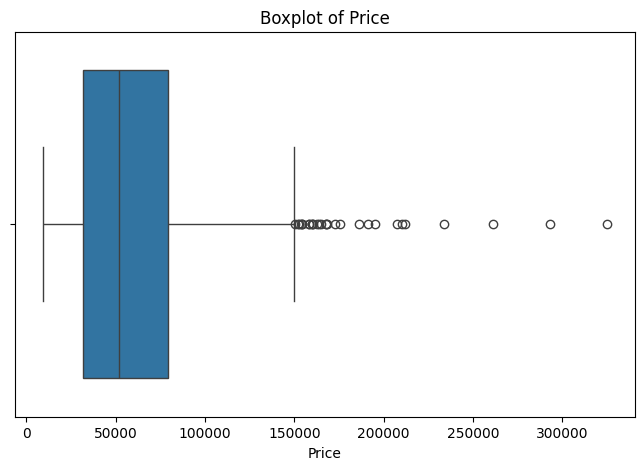

In [1897]:
# Create the boxplot of target variable
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["price"])

plt.title("Boxplot of Price")
plt.xlabel("Price")

# Show the plot
plt.show()

Extract usefull inforamtion from columns and correct dtypes

In [1898]:
import re

def extract_storage_size(memory):
    ssd_size = re.search(r'(\d+)(?:gb|tb) ssd', memory)
    hdd_size = re.search(r'(\d+)(?:gb|tb) hdd', memory)
    hybrid_size = re.search(r'(\d+(?:\.\d+)?)tb hybrid', memory)
    flash_size = re.search(r'(\d+)gb flash storage', memory)

    ssd_size_gb = int(float(ssd_size.group(1)) * 1024) if ssd_size and 'tb' in ssd_size.group() else int(ssd_size.group(1)) if ssd_size else 0
    hdd_size_gb = int(hdd_size.group(1)) * 1024 if hdd_size and 'tb' in hdd_size.group() else int(hdd_size.group(1)) if hdd_size else 0
    hybrid_size_gb = int(float(hybrid_size.group(1)) * 1024) if hybrid_size else 0
    flash_size_gb = int(flash_size.group(1)) if flash_size else 0

    return ssd_size_gb, hdd_size_gb, hybrid_size_gb, flash_size_gb

df['ssd'], df['hdd'], df['hybrid'], df['flash storage'] = zip(*df['memory'].apply(extract_storage_size))
df['total storage'] = df['ssd'] + df['hdd'] + df['hybrid'] + df['flash storage']
df.sample(5)


,company,typename,inches,screenresolution,cpu,ram,memory,gpu,opsys,weight,price,ssd,hdd,hybrid,flash storage,total storage
1111,dell,notebook,15.6,1366x768,intel core i5 6200u 2.3ghz,4gb,500gb hdd,amd radeon r5 m315,windows 7,2.24kg,40980.3120,0,500,0,0,500
460,acer,notebook,15.6,full hd 1920x1080,intel core i3 6006u 2ghz,4gb,1tb hdd,nvidia geforce 940mx,windows 10,2.23kg,28984.3200,0,1024,0,0,1024
602,acer,notebook,14.0,full hd 1920x1080,intel celeron quad core n3450 1.1ghz,4gb,32gb flash storage,intel hd graphics 500,windows 10,1.6kg,17529.1200,0,0,0,32,32
1260,lenovo,2 in 1 convertible,14.0,full hd / touchscreen 1920x1080,intel core i5 6200u 2.3ghz,4gb,128gb ssd,intel hd graphics 520,windows 10,1.8kg,44382.7728,128,0,0,0,128
818,dell,gaming,17.3,ips panel full hd 1920x1080,intel core i7 7700hq 2.8ghz,16gb,128gb ssd + 1tb hdd,nvidia geforce gtx 1060,windows 10,4.36kg,133467.4656,128,1024,0,0,1152


In [1899]:
# convert ram column to numerical by extracting
df["ram_gb"] = df["ram"].str.replace("gb", "").astype(int)
df['ram_gb'].unique()

array([ 8, 16,  4,  2, 12,  6, 32, 24, 64])

In [1900]:
# Remove "kg" suffix and convert to numeric values
df["weight"] = df["weight"].str.replace("kg", "").astype(float)

# Show the cleaned DataFrame
print(df[["weight"]].head())  # Preview the weight column after cleaning


   weight
0    1.37
1    1.34
2    1.86
3    1.83
4    1.37


In [1901]:
# Get unique values from 'cpu_model' column
unique_cpu_models = df['cpu'].unique()

# Display the unique values
print(unique_cpu_models)


['intel core i5 2.3ghz' 'intel core i5 1.8ghz'
 'intel core i5 7200u 2.5ghz' 'intel core i7 2.7ghz'
 'intel core i5 3.1ghz' 'amd a9-series 9420 3ghz' 'intel core i7 2.2ghz'
 'intel core i7 8550u 1.8ghz' 'intel core i5 8250u 1.6ghz'
 'intel core i3 6006u 2ghz' 'intel core i7 2.8ghz'
 'intel core m m3 1.2ghz' 'intel core i7 7500u 2.7ghz'
 'intel core i7 2.9ghz' 'intel core i3 7100u 2.4ghz'
 'intel atom x5-z8350 1.44ghz' 'intel core i5 7300hq 2.5ghz'
 'amd e-series e2-9000e 1.5ghz' 'intel core i5 1.6ghz'
 'intel core i7 8650u 1.9ghz' 'intel atom x5-z8300 1.44ghz'
 'amd e-series e2-6110 1.5ghz' 'amd a6-series 9220 2.5ghz'
 'intel celeron dual core n3350 1.1ghz' 'intel core i3 7130u 2.7ghz'
 'intel core i7 7700hq 2.8ghz' 'intel core i5 2.0ghz'
 'amd ryzen 1700 3ghz' 'intel pentium quad core n4200 1.1ghz'
 'intel atom x5-z8550 1.44ghz' 'intel celeron dual core n3060 1.6ghz'
 'intel core i5 1.3ghz' 'amd fx 9830p 3ghz' 'intel core i7 7560u 2.4ghz'
 'amd e-series 6110 1.5ghz' 'intel core i5 620

In [1902]:
df['cpu name'] = df['cpu'].apply(lambda x:' '.join(x.split()[ : 3]))

def fetch_processor(data):
    if data in {'intel core i7','intel core i5', 'intel core i3'}:
        return data
    elif 'intel' in data:
        return 'Other Intel Processor'
    elif 'samsung' in data:
        return 'samsung'
    return 'AMD Processor'


In [1903]:
df['cpu brand'] = df['cpu name'].apply(fetch_processor)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'intel core i5'),
  Text(1, 0, 'intel core i7'),
  Text(2, 0, 'AMD Processor'),
  Text(3, 0, 'intel core i3'),
  Text(4, 0, 'Other Intel Processor'),
  Text(5, 0, 'samsung')])

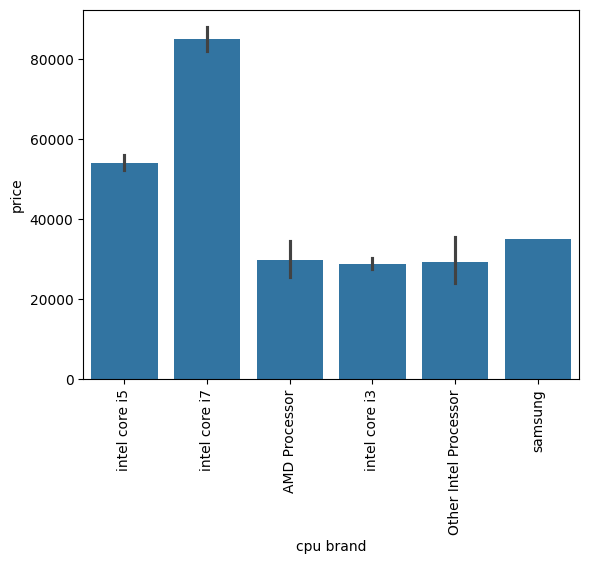

In [1904]:
df['cpu brand'].value_counts()
sns.barplot(x = df['cpu brand'], y = df['price'])
plt.xticks(rotation = 'vertical')

In [1905]:
import re

# Function to extract screen resolution and check for touchscreen
def extract_screen_details(resolution):
    # Regex to capture common screen resolutions (e.g., 1920x1080)
    match = re.search(r'(\d{3,4}x\d{3,4})', resolution.lower())
    screen_resolution = match.group(0) if match else None
    
    # Check if 'touchscreen' is mentioned
    is_touch = 1 if 'touchscreen' in resolution.lower() else 0
    
    return screen_resolution, is_touch

# Apply function to extract resolution and touchscreen info
df[['screen_resolution', 'is_touchscreen']] = df['screenresolution'].apply(lambda x: pd.Series(extract_screen_details(x)))

# Show cleaned DataFrame with resolution and touchscreen in
print(df[['screenresolution', 'screen_resolution', 'is_touchscreen']].head())  # Preview the data



                     screenresolution screen_resolution  is_touchscreen
0  ips panel retina display 2560x1600         2560x1600               0
1                            1440x900          1440x900               0
2                   full hd 1920x1080         1920x1080               0
3  ips panel retina display 2880x1800         2880x1800               0
4  ips panel retina display 2560x1600         2560x1600               0


In [1906]:
import pandas as pd
import re

# Function to extract GPU manufacturer and graphics type
def extract_gpu_info(gpu):
    # Regex to capture manufacturer (Intel, AMD, Nvidia) and graphics type (e.g., Iris, GeForce, Radeon)
    match = re.search(r'(intel|amd|nvidia)\s*(iris|radeon|geforce|hd|uhd)?\s*(graphics|pro|plus|)\s*', gpu.lower())
    if match:
        manufacturer = match.group(1).capitalize()
        graphics_type = match.group(2) if match.group(2) else 'Unknown'  # Default to 'Unknown' if no graphics type
        return manufacturer, graphics_type
    return 'Unknown', 'Unknown'


# Apply the function to extract GPU manufacturer and graphics type
df[['gpu_manufacturer', 'gpu_graphics_type']] = df['gpu'].apply(lambda x: pd.Series(extract_gpu_info(x)))

# Show the result with manufacturer and graphics type
print(df[['gpu', 'gpu_manufacturer', 'gpu_graphics_type']])


                               gpu gpu_manufacturer gpu_graphics_type
0     intel iris plus graphics 640            Intel              iris
1           intel hd graphics 6000            Intel                hd
2            intel hd graphics 620            Intel                hd
3               amd radeon pro 455              Amd            radeon
4     intel iris plus graphics 650            Intel              iris
...                            ...              ...               ...
1298         intel hd graphics 520            Intel                hd
1299         intel hd graphics 520            Intel                hd
1300             intel hd graphics            Intel                hd
1301            amd radeon r5 m330              Amd            radeon
1302             intel hd graphics            Intel                hd

[1303 rows x 3 columns]


In [1907]:
def cat_OS(inp):
    if inp in {'windows 10', 'windows 7', 'windows 10 S'}:
        return 'windows'
    elif inp in {'mac os x', 'macos'}:
        return 'mac'
    else:
        return 'others/no os/linux'
    
df['os'] = df['opsys'].apply(cat_OS)
df.head()


,company,typename,inches,screenresolution,cpu,ram,memory,gpu,opsys,weight,...,flash storage,total storage,ram_gb,cpu name,cpu brand,screen_resolution,is_touchscreen,gpu_manufacturer,gpu_graphics_type,os
0,apple,ultrabook,13.3,ips panel retina display 2560x1600,intel core i5 2.3ghz,8gb,128gb ssd,intel iris plus graphics 640,macos,1.37,...,0,128,8,intel core i5,intel core i5,2560x1600,0,Intel,iris,mac
1,apple,ultrabook,13.3,1440x900,intel core i5 1.8ghz,8gb,128gb flash storage,intel hd graphics 6000,macos,1.34,...,128,128,8,intel core i5,intel core i5,1440x900,0,Intel,hd,mac
2,hp,notebook,15.6,full hd 1920x1080,intel core i5 7200u 2.5ghz,8gb,256gb ssd,intel hd graphics 620,no os,1.86,...,0,256,8,intel core i5,intel core i5,1920x1080,0,Intel,hd,others/no os/linux
3,apple,ultrabook,15.4,ips panel retina display 2880x1800,intel core i7 2.7ghz,16gb,512gb ssd,amd radeon pro 455,macos,1.83,...,0,512,16,intel core i7,intel core i7,2880x1800,0,Amd,radeon,mac
4,apple,ultrabook,13.3,ips panel retina display 2560x1600,intel core i5 3.1ghz,8gb,256gb ssd,intel iris plus graphics 650,macos,1.37,...,0,256,8,intel core i5,intel core i5,2560x1600,0,Intel,iris,mac


In [1908]:
# convert Screenresolution 
# Remove non-numeric characters except 'x' for screen resolution
df['screen_resolution'] = df['screen_resolution'].str.replace(r'[^\dX]', '', regex=True)

df['ScreenResolution_Width'] = df['screen_resolution'].str[:4].astype(int)
df['ScreenResolution_Height'] = df['screen_resolution'].str[4:].astype(int)

In [1909]:
# columns where info has been extracted from
columns_to_drop = ['gpu', 'ram', 'memory', 'cpu', 'screen_resolution', 'screenresolution', 'opsys', 'cpu name']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

In [1910]:
df.head()

,company,typename,inches,weight,price,ssd,hdd,hybrid,flash storage,total storage,ram_gb,cpu brand,is_touchscreen,gpu_manufacturer,gpu_graphics_type,os,ScreenResolution_Width,ScreenResolution_Height
0,apple,ultrabook,13.3,1.37,71378.6832,128,0,0,0,128,8,intel core i5,0,Intel,iris,mac,2560,1600
1,apple,ultrabook,13.3,1.34,47895.5232,0,0,0,128,128,8,intel core i5,0,Intel,hd,mac,1440,900
2,hp,notebook,15.6,1.86,30636.0000,256,0,0,0,256,8,intel core i5,0,Intel,hd,others/no os/linux,1920,1080
3,apple,ultrabook,15.4,1.83,135195.3360,512,0,0,0,512,16,intel core i7,0,Amd,radeon,mac,2880,1800
4,apple,ultrabook,13.3,1.37,96095.8080,256,0,0,0,256,8,intel core i5,0,Intel,iris,mac,2560,1600


In [1911]:
df.nunique()

company                     19
typename                     6
inches                      18
weight                     171
price                      791
ssd                         11
hdd                          6
hybrid                       2
flash storage                7
total storage               21
ram_gb                       9
cpu brand                    6
is_touchscreen               2
gpu_manufacturer             4
gpu_graphics_type            6
os                           3
ScreenResolution_Width      13
ScreenResolution_Height     10
dtype: int64

In [1912]:
# Show the count of missing values for each column
missing_values_per_column = df.isnull().sum()

# Display the result
print("Missing values per column:")
print(missing_values_per_column)

print(df.duplicated().sum())


Missing values per column:
company                    0
typename                   0
inches                     0
weight                     0
price                      0
ssd                        0
hdd                        0
hybrid                     0
flash storage              0
total storage              0
ram_gb                     0
cpu brand                  0
is_touchscreen             0
gpu_manufacturer           0
gpu_graphics_type          0
os                         0
ScreenResolution_Width     0
ScreenResolution_Height    0
dtype: int64
30


Visualize

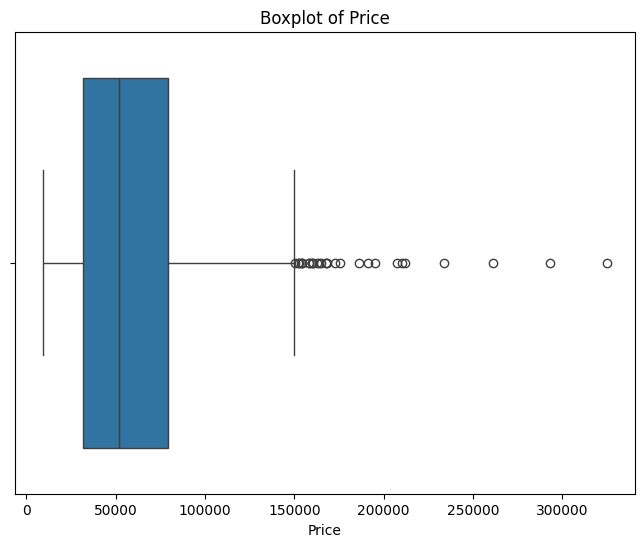

In [1913]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for price
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['price'])
plt.title('Boxplot of Price')
plt.xlabel('Price')
plt.show()


In [1914]:

# Separate numerical and categorical columns
num_features = df.select_dtypes(include=['number']).columns  # Select numerical columns
cat_features = df.select_dtypes(exclude=['number']).columns  # Select categorical columns

df[cat_features] = df[cat_features].astype("category")


print("Numerical Features:", num_features.tolist())
print("Categorical Features:", cat_features.tolist())


Numerical Features: ['inches', 'weight', 'price', 'ssd', 'hdd', 'hybrid', 'flash storage', 'total storage', 'ram_gb', 'is_touchscreen', 'ScreenResolution_Width', 'ScreenResolution_Height']
Categorical Features: ['company', 'typename', 'cpu brand', 'gpu_manufacturer', 'gpu_graphics_type', 'os']


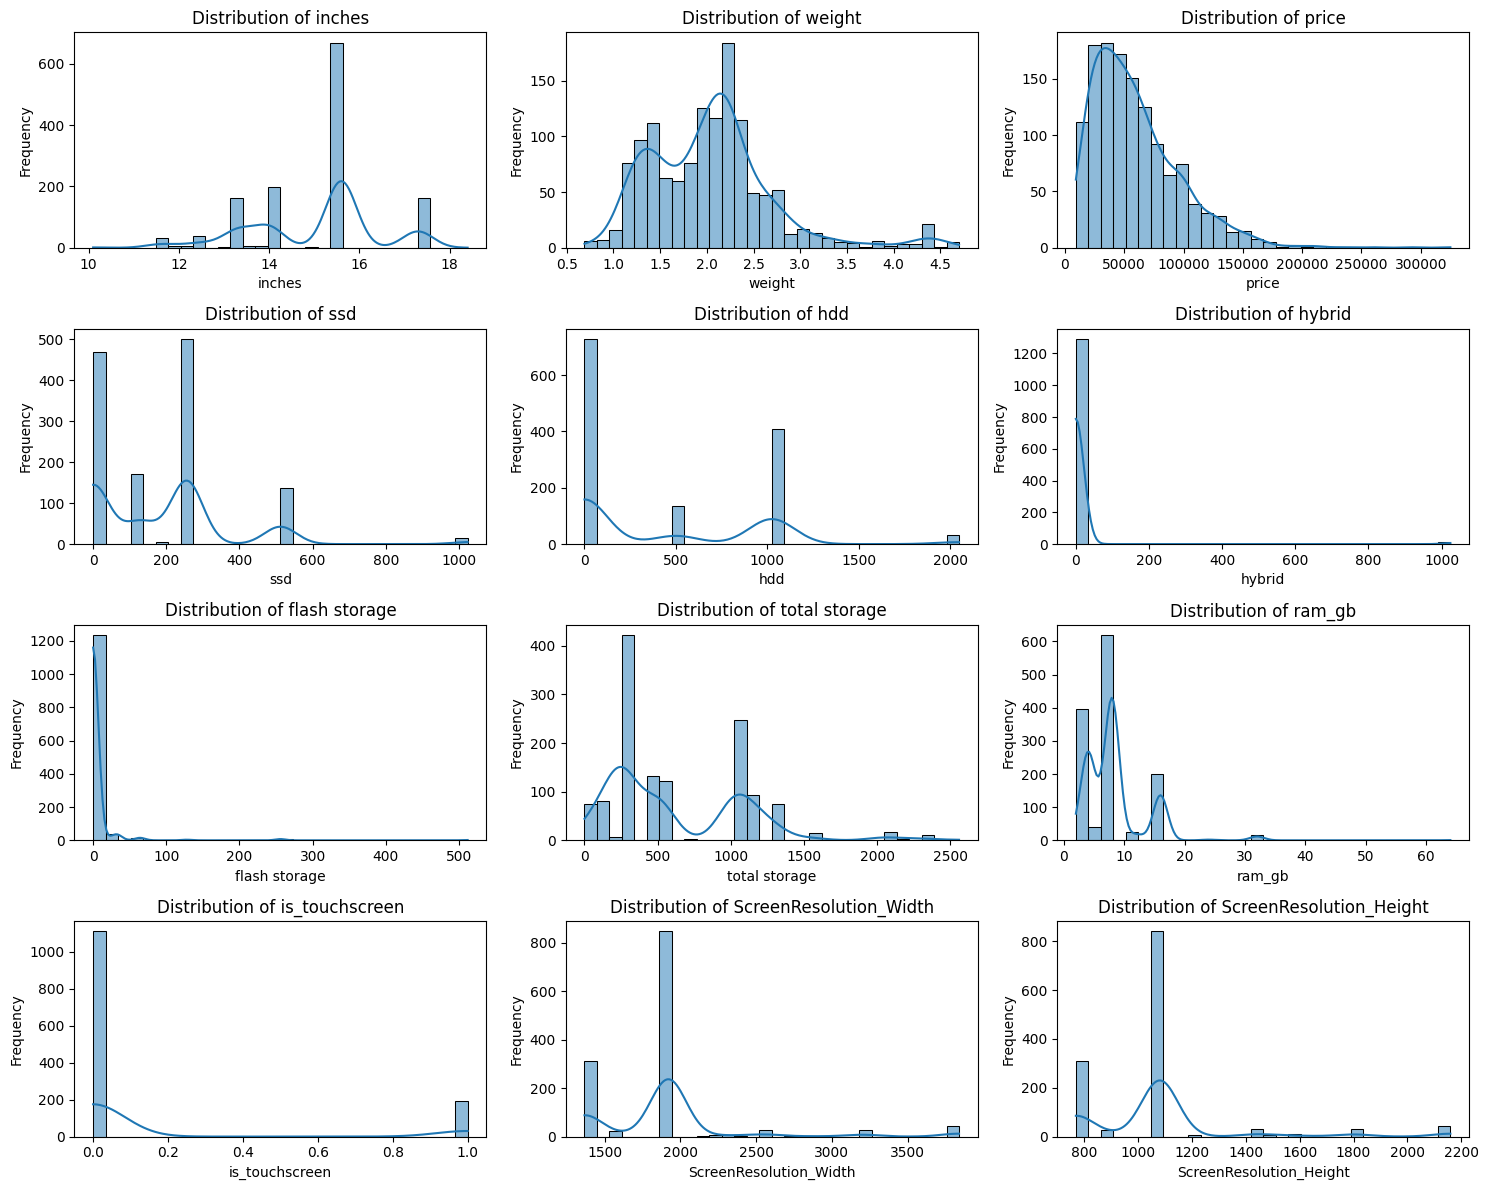

In [1915]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))

# Determine the number of rows needed dynamically
cols_per_row = 3  # Adjust this if needed
num_plots = len(num_features)
num_rows = (num_plots + cols_per_row - 1) // cols_per_row  # Compute needed rows

for i, col in enumerate(num_features, 1):
    plt.subplot(num_rows, cols_per_row, i)  # Adjust grid dynamically
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


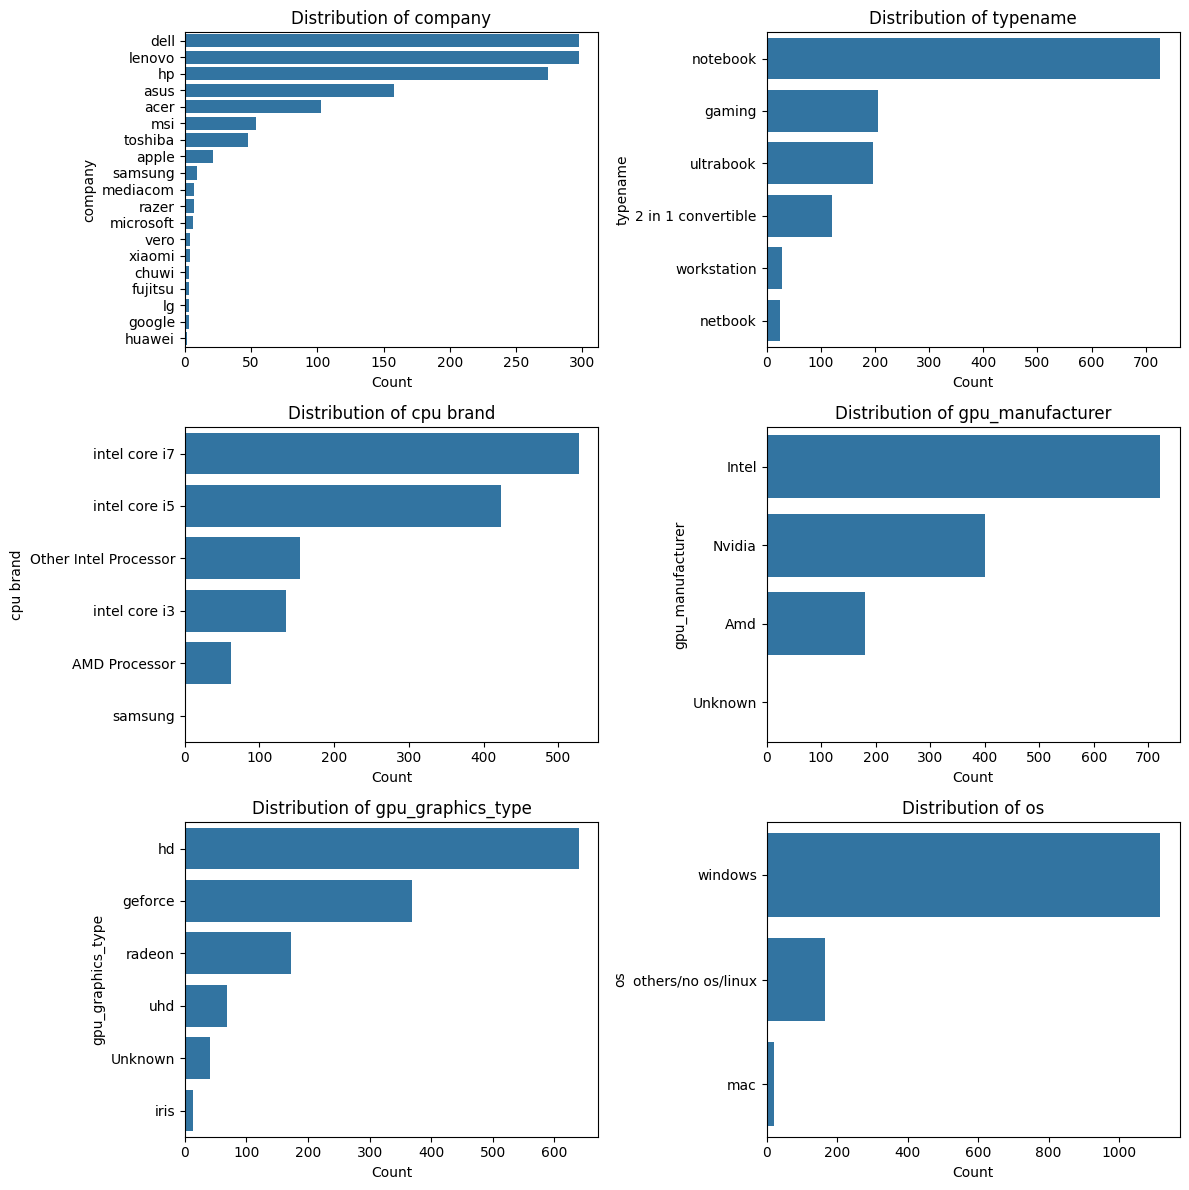

In [1916]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define number of rows and columns for subplots
num_cats = len(cat_features)
cols = 2  # Number of columns
rows = math.ceil(num_cats / cols)  # Adjust rows dynamically

plt.figure(figsize=(12, rows * 4))  # Adjust height dynamically

for i, col in enumerate(cat_features, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(y=df[col], order=df[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col)

plt.tight_layout()
plt.show()


In [1917]:
# import pandas as pd

# # Define the threshold percentage (e.g., 5%)
# threshold = 0.03 * len(df)  # 5% of total rows

# # Function to replace infrequent categories with "Other"
# def group_rare_categories(column):
#     counts = df[column].value_counts()
#     rare_categories = counts[counts < threshold].index
#     df[column] = df[column].replace(rare_categories, 'Other')

# # Apply to all categorical columns

# for col in cat_features:
#     group_rare_categories(col)

# # Check updated categories
# for col in cat_features:
#     print(f"Unique values in {col}: {df[col].unique()}")


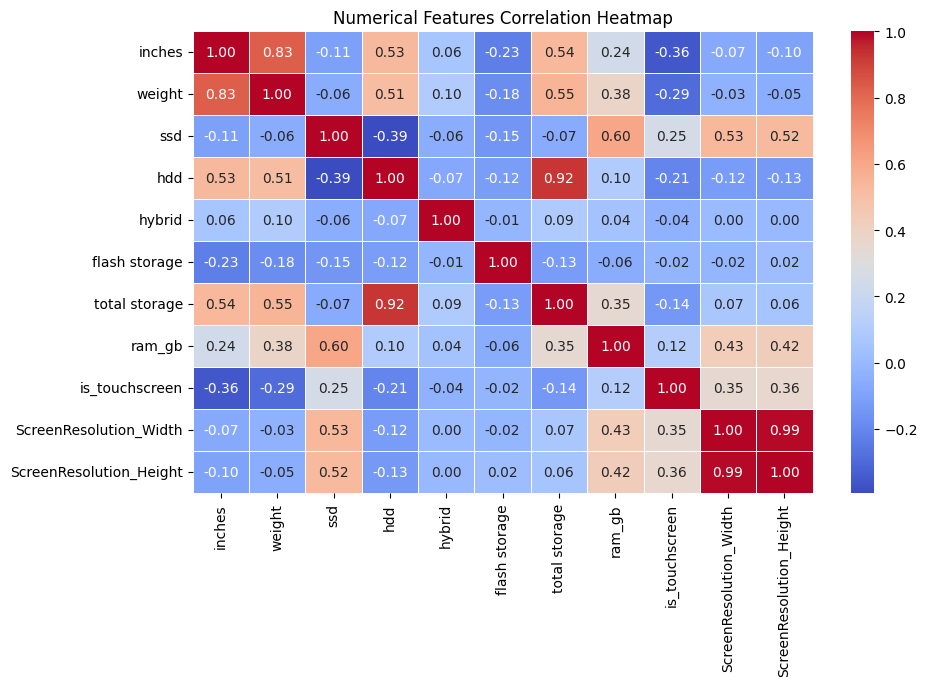

In [1918]:
import seaborn as sns
import matplotlib.pyplot as plt

X= df.drop('price', axis=1)
y= df['price']

# Automatically detect numerical and categorical features after removing target
num_features = X.select_dtypes(include=['number']).columns.tolist()
cat_features = X.select_dtypes(exclude=['number']).columns.tolist()

# Compute correlation matrix (only for numerical features, excluding target)
corr_matrix = X[num_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Numerical Features Correlation Heatmap")
plt.show()


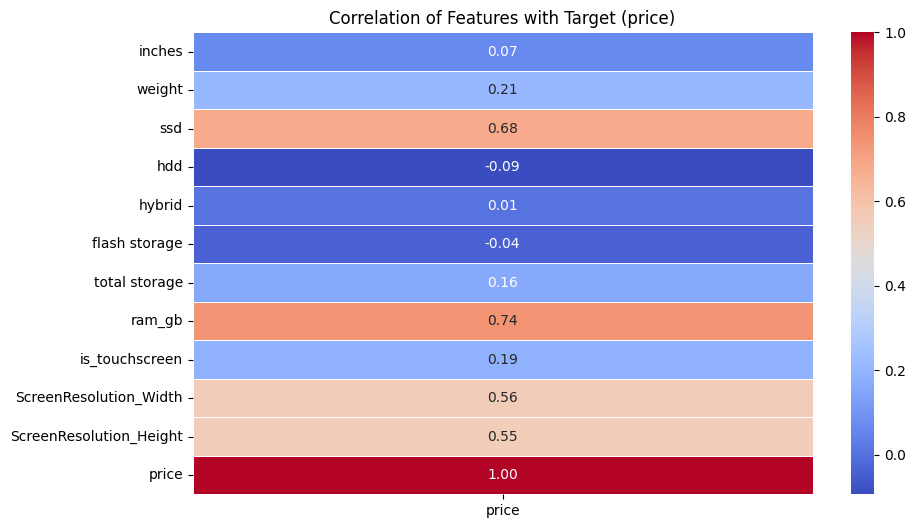

In [1919]:
# Compute correlation with target variable (log_price or price)
corr_with_target = X[num_features].join(y).corr()['price']  # or use 'price' if not log-transformed

# Plot heatmap for correlations with target only
plt.figure(figsize=(10, 6))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation of Features with Target (price)")
plt.show()


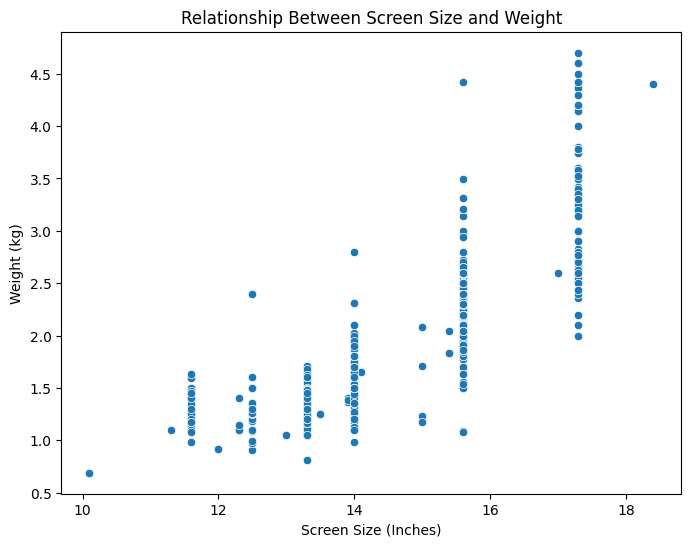

In [1920]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['inches'], y=df['weight'])
plt.xlabel("Screen Size (Inches)")
plt.ylabel("Weight (kg)")
plt.title("Relationship Between Screen Size and Weight")
plt.show()


In [1921]:
# drop or change features that have high correlation
df['weight_per_inch'] = df['weight'] / df['inches']

df['total storage']

columns_to_drop= ['ScreenResolution_Width', 'inches', 'weight', 'total storage'] 
df= df.drop(columns_to_drop, axis =1)

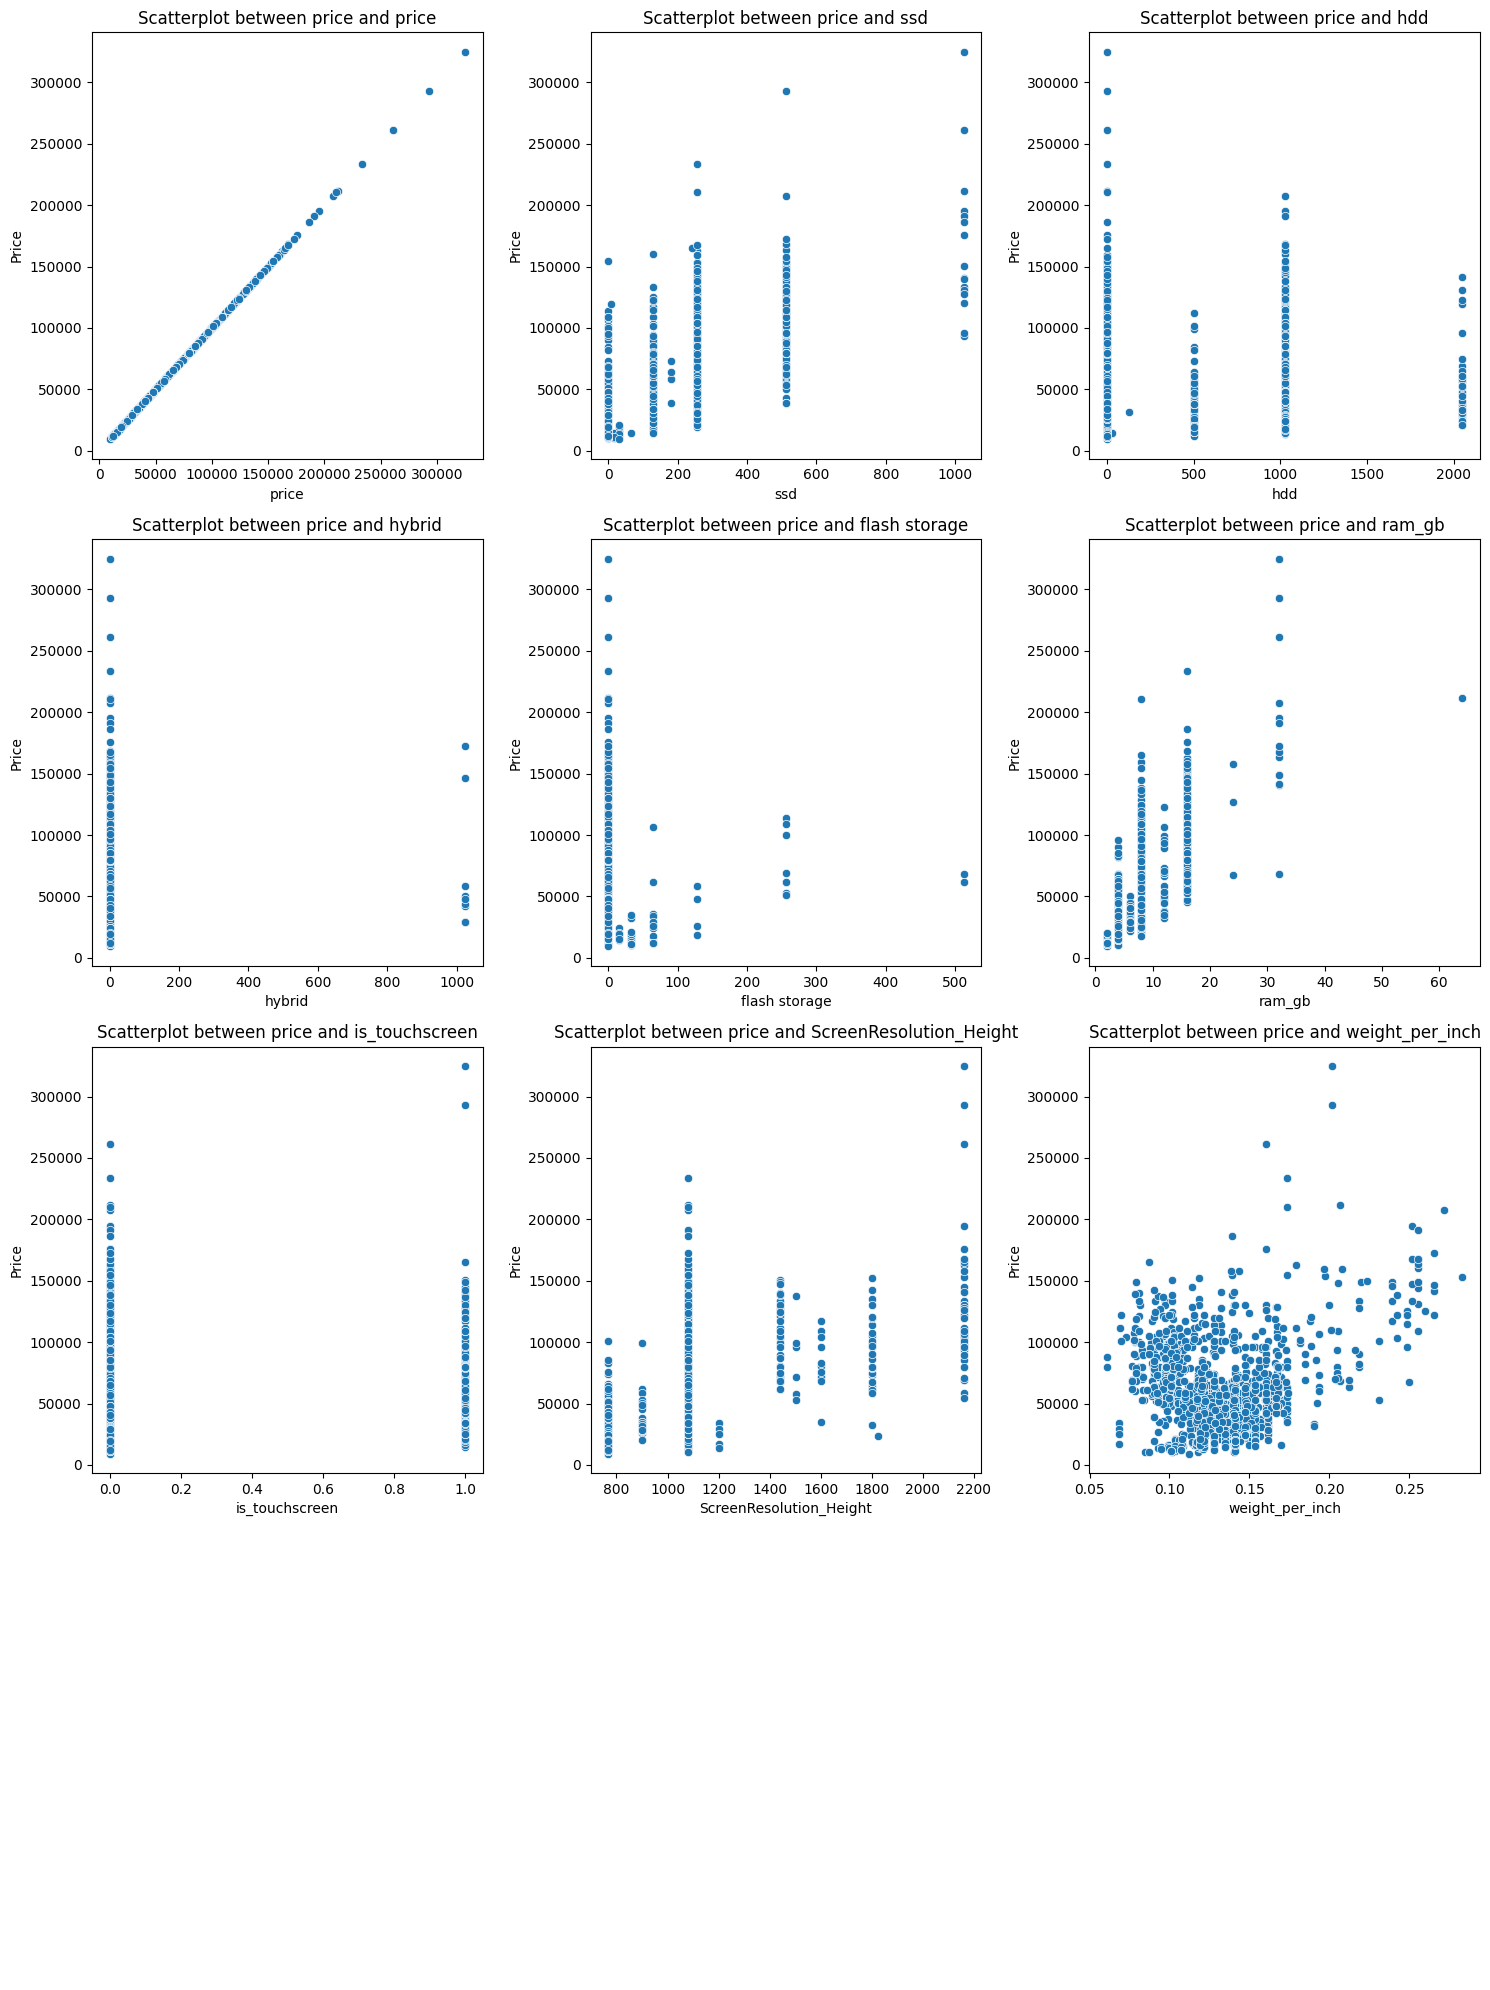

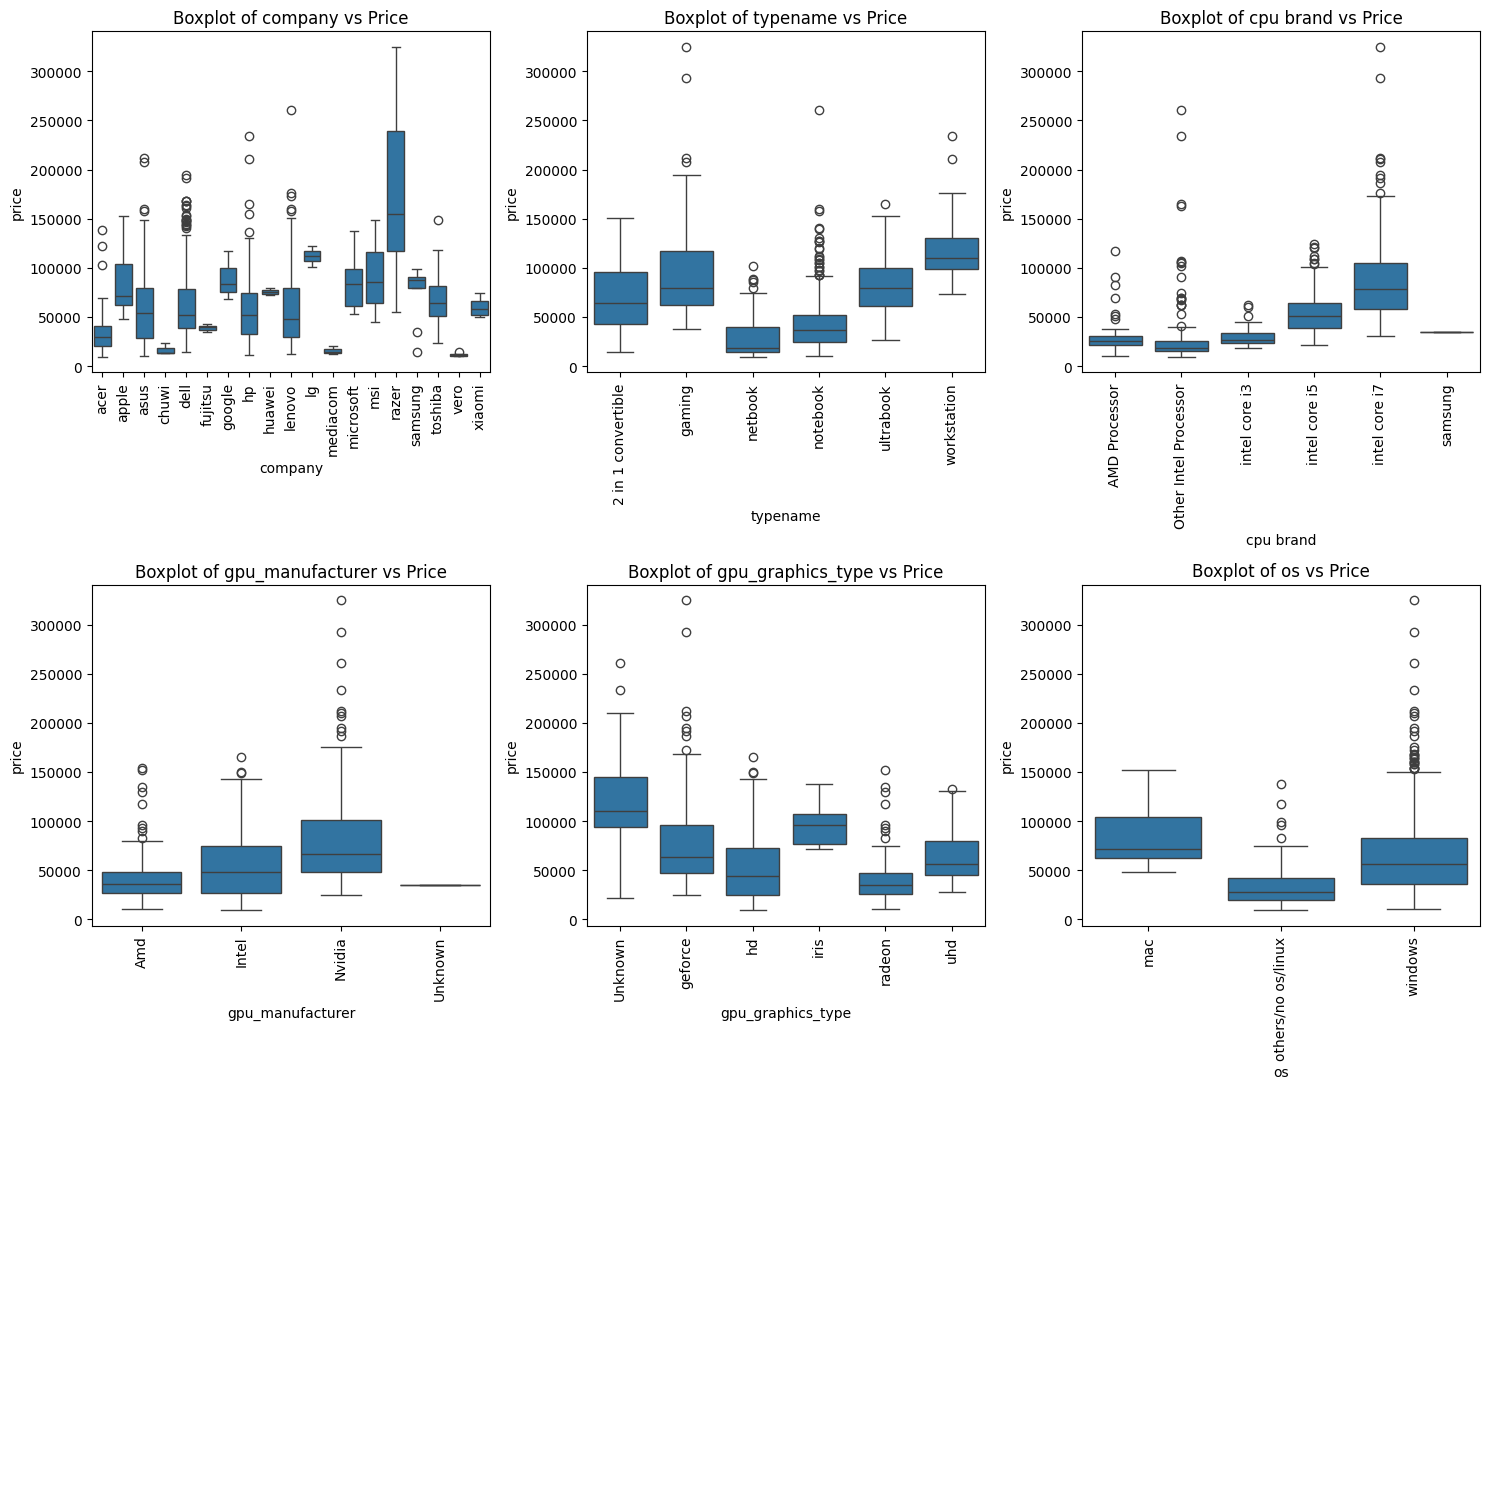

In [1922]:
import seaborn as sns
import matplotlib.pyplot as plt


# Automatically detect numerical and categorical features after removing target
num_features = df.select_dtypes(include=['number']).columns.tolist()
cat_features = df.select_dtypes(exclude=['number']).columns.tolist()

# Number of plots per row
plots_per_row = 3

# Scatterplots for numerical features
n_rows = len(num_features) // plots_per_row + 1  # Calculate the number of rows needed

fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Loop through the features and create scatterplots with 'price'
for i, feature in enumerate(num_features):
    sns.scatterplot(x= df[feature], y= df['price'], ax=axes[i])
    axes[i].set_title(f'Scatterplot between price and {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Price')

# Remove any unused subplots
for i in range(len(num_features), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Boxplots for categorical features vs price
n_rows_cat = len(cat_features) // plots_per_row + 1  # Calculate the number of rows needed for cat features

fig_cat, axes_cat = plt.subplots(n_rows_cat, plots_per_row, figsize=(15, 5 * n_rows_cat))
axes_cat = axes_cat.flatten()

for i, feature in enumerate(cat_features):
    sns.boxplot(x=df[feature], y=df['price'], ax=axes_cat[i])
    axes_cat[i].set_title(f'Boxplot of {feature} vs Price')
    axes_cat[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

# Remove any unused subplots
for i in range(len(cat_features), len(axes_cat)):
    axes_cat[i].axis('off')

plt.tight_layout()
plt.show()


In [1923]:
numerical_cols = df.select_dtypes(include=['number']).columns
numerical_df = df[numerical_cols]

correlation = numerical_df.corr()['price']
correlation

price                      1.000000
ssd                        0.675986
hdd                       -0.093112
hybrid                     0.008822
flash storage             -0.040511
ram_gb                     0.743007
is_touchscreen             0.191226
ScreenResolution_Height    0.552809
weight_per_inch            0.205512
Name: price, dtype: float64

since the target variable 'price' is right skewed, we will log transform it to improve the prediction performance of the algorithms.

In [1924]:
# Log-transform the price to handle skewness
df['price'] = np.log1p(df['price'])

# Split into features (X) and target (y)
X = df.drop(['price'], axis=1)  
y = df['price']  

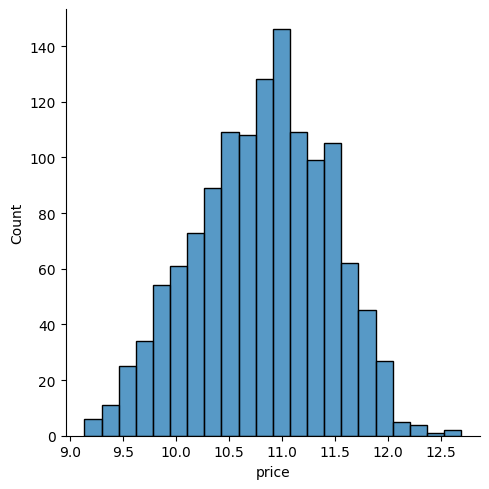

In [1925]:
sns.displot(y)
plt.show()

In [1926]:
# Detect numerical and categorical features
num_features = X.select_dtypes(include=['number']).columns.tolist()
cat_features = X.select_dtypes(exclude=['number']).columns.tolist()

In [1927]:

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

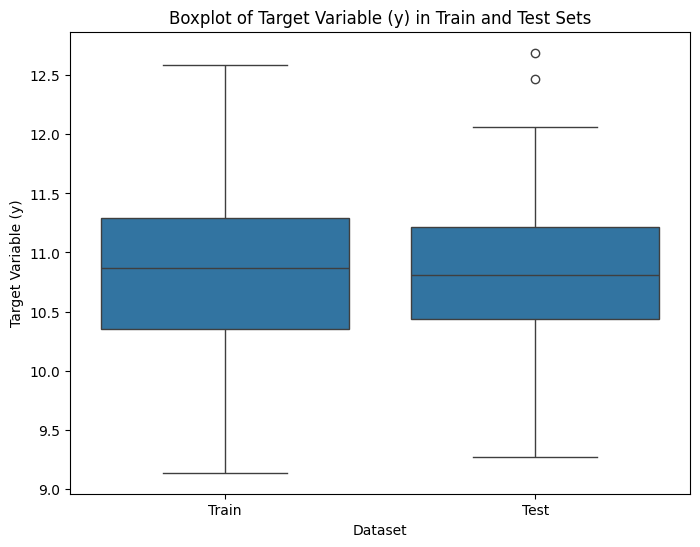

In [1928]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine y_train and y_test into a single DataFrame for plotting
y_train_df = pd.DataFrame({'y': y_train, 'Set': 'Train'})
y_test_df = pd.DataFrame({'y': y_test, 'Set': 'Test'})
combined_df = pd.concat([y_train_df, y_test_df])

# Plot boxplot of the target variable (y) in training and testing sets
plt.figure(figsize=(8, 6))
sns.boxplot(x='Set', y='y', data=combined_df)

# Add title and labels
plt.title('Boxplot of Target Variable (y) in Train and Test Sets')
plt.xlabel('Dataset')
plt.ylabel('Target Variable (y)')

# Display the plot
plt.show()


An encoding by one hot encoding would be preferrable in this case since there is not a order/hierarchy among the different categories for each variable. 

But since the tabla only has 1303 rows, we will label encode the company table (19 categories) and OHE the others


In [1929]:
# give unique categorical variables 

X[cat_features].nunique()

company              19
typename              6
cpu brand             6
gpu_manufacturer      4
gpu_graphics_type     6
os                    3
dtype: int64

In [1930]:
# Custom transformer for Label Encoding
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}

    def fit(self, X, y=None):
        # Fit LabelEncoder on each unique column
        for col in X.columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.label_encoders[col] = le
        return self

    def transform(self, X):
        # Transform each column using the corresponding LabelEncoder
        X_transformed = X.copy()
        for col, le in self.label_encoders.items():
            X_transformed[col] = le.transform(X[col])
        return X_transformed



# Preprocessing steps
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Label encoding for 'Company' column only
label_encoder = LabelEncoderTransformer()

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('company', label_encoder, ['company']),  # Apply label encoding for 'Company'
    ('cat', cat_transformer, [col for col in cat_features if col != 'company'])  # Exclude 'Company' from OneHotEncoder
])

# Create a pipeline with Linear Regression
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  
])

# Train the model
model_pipeline.fit(X_train, y_train)


# Predictions (on log scale)
y_pred_log = model_pipeline.predict(X_test)
y_test_log = y_test

# Inverse log transformation to get actual price predictions
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

# Evaluation metrics for log values
mae_log = mean_absolute_error(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
r2_log = r2_score(y_test_log, y_pred_log)

# Evaluation metrics for original price values (non-log scale)
mae_original = mean_absolute_error(y_test_original, y_pred)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2_original = r2_score(y_test_original, y_pred)

# Print results
print(f"Log-Scale MAE: {mae_log:.2f}")
print(f"Log-Scale RMSE: {rmse_log:.2f}")
print(f"Log-Scale R²: {r2_log:.2f}")

print(f"Original Price MAE: {mae_original:.2f}")
print(f"Original Price RMSE: {rmse_original:.2f}")
print(f"Original Price R²: {r2_original:.2f}")

Log-Scale MAE: 0.20
Log-Scale RMSE: 0.25
Log-Scale R²: 0.82
Original Price MAE: 11943.72
Original Price RMSE: 17796.65
Original Price R²: 0.78


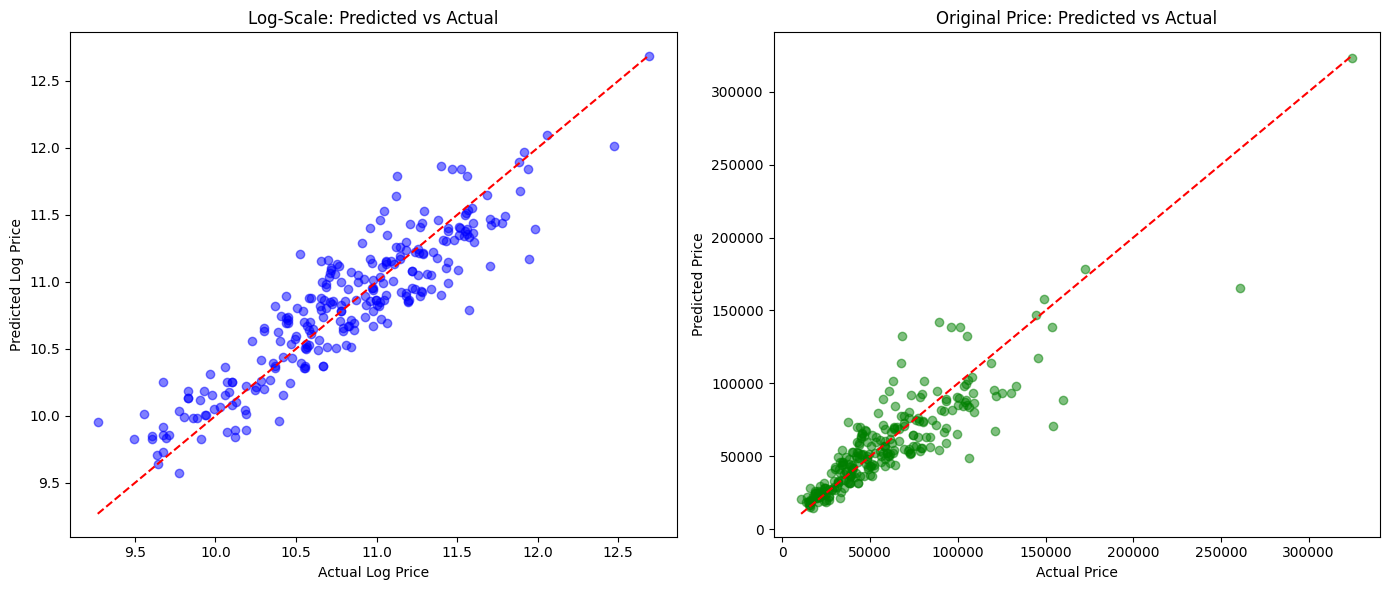

In [1933]:
# Plotting predicted vs actual values for both log and original price

# Plot for Log-Scale
plt.figure(figsize=(14, 6))

# Subplot for Log-Scale Predicted vs Actual
plt.subplot(1, 2, 1)
plt.scatter(y_test_log, y_pred_log, color='blue', alpha=0.5)
plt.plot([min(y_test_log), max(y_test_log)], [min(y_test_log), max(y_test_log)], color='red', linestyle='--')  # Line of equality
plt.title('Log-Scale: Predicted vs Actual')
plt.xlabel('Actual Log Price')
plt.ylabel('Predicted Log Price')

# Subplot for Original Price Predicted vs Actual
plt.subplot(1, 2, 2)
plt.scatter(y_test_original, y_pred, color='green', alpha=0.5)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')  # Line of equality
plt.title('Original Price: Predicted vs Actual')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')

plt.tight_layout()
plt.show()

In [1934]:
from sklearn.linear_model import LassoCV

# Create a pipeline with LassoCV for Lasso regression with alpha tuning
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(cv=10, random_state=42, max_iter=100000))  # LassoCV automatically handles alpha tuning via cross-validation
])

# Train the model
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ssd', 'hdd', 'hybrid',
                                                   'flash storage', 'ram_gb',
                                                   'is_touchscreen',
                                                   'ScreenResolution_Height',
                                                   'weight_per_inch']),
                                                 ('company',
                                                  LabelEncoderTransformer(),
                                                  ['company']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['typename', 'cpu brand',
                                                   'gpu_manufacturer',
                                                   'gpu_graphics_type',
                                                   'os'])])),
                ('regressor',
                 LassoCV(cv=10, max_iter=100000, random_state=42))])

In [1935]:

# Predictions (on log scale)
y_pred_log = model_pipeline.predict(X_test)
y_test_log = y_test

# Inverse log transformation to get actual price predictions
y_pred = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

# Evaluation metrics for log values
mae_log = mean_absolute_error(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
r2_log = r2_score(y_test_log, y_pred_log)

# Evaluation metrics for original price values (non-log scale)
mae_original = mean_absolute_error(y_test_original, y_pred)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2_original = r2_score(y_test_original, y_pred)

# Print results
print(f"Log-Scale MAE: {mae_log:.2f}")
print(f"Log-Scale RMSE: {rmse_log:.2f}")
print(f"Log-Scale R²: {r2_log:.2f}")

print(f"Original Price MAE: {mae_original:.2f}")
print(f"Original Price RMSE: {rmse_original:.2f}")
print(f"Original Price R²: {r2_original:.2f}")


Log-Scale MAE: 0.20
Log-Scale RMSE: 0.25
Log-Scale R²: 0.82
Original Price MAE: 11967.83
Original Price RMSE: 17928.12
Original Price R²: 0.78


On the log scale, the R² might be higher because the transformation reduces the effect of outliers, making the model fit the data better.
On the original scale, the R² might be lower because large values that were compressed by the log transformation may cause the model's errors to appear larger and more significant



### **Evaluation of the Model's Performance**  

The model's performance was assessed using both log-transformed and original price metrics. The log-transformation was applied to address skewness in the dataset and improve model stability.  

In the **log-transformed space**, the model achieved an **R² of 0.82**, indicating that it explains 82% of the variance in laptop prices. The **log-scale MAE (0.20) and RMSE (0.25)** suggest that the model performs well in predicting log-transformed prices with relatively small errors.  

However, when evaluating performance on the **original price scale**, the results showed some limitations. The **R² of 0.78** indicates a fairly strong fit, but the **MAE of €11,967 and RMSE of €17,928** suggest that absolute prediction errors remain significant. Given the dataset's characteristics—where **the median price is around €50,000, the interquartile range is from around €10,000 to €150,000, and extreme outliers reach up to €350,000**—the model appears to perform well for most typical laptop prices but struggles with extreme values.  

The presence of **high-priced outliers** likely contributes to the large RMSE, as these extreme values introduce significant prediction deviations. 

Impact of Regularization (Lasso Regression)
To improve feature selection and reduce overfitting, Lasso regression (LassoCV) was introduced. However, the results showed minimal impact on performance. This indicates that:

Most features were already relevant, so Lasso did not significantly improve predictions.
Lasso's regularization strength (alpha) may not have been optimal, as automatic tuning did not show clear benefits.

Overall, the model successfully captures the general pricing trends in the dataset, but **further refinement is needed to reduce absolute errors and handle outliers more effectively**.  
